## Step 1 (Preparation & Utility): 

In [1]:
""" Import Libraries """

import numpy as np
import pandas as pd
import scipy as sp
import scipy.optimize
import scipy.integrate
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from gplearn.genetic import SymbolicRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils.random import check_random_state
import os
from scipy import interpolate


#plt.style.use(['science', 'notebook']) # choose plotting style

plt.style.use('ggplot')

os.getcwd()

'C:\\Users\\moche\\Documents\\working_programs'

In [2]:
" Data Importing "

# Extract dataframe from .csv and turn to numpy array
df = pd.read_csv('Lip_space_time-17-Nov-2021.csv') 
data = df.to_numpy()

# Remove NaN columns 
adj_data = np.delete(data,[7,12,13,14],1) # Removed PI45P2, Carmil, ArpB & PI4P columns 

# Extract column values separately 
gDistance = adj_data[:,0]
time = adj_data[:,1]
Curvature = adj_data[:,2]
PIP3 = adj_data[:,3]
Actin= adj_data[:,4]
NAP = adj_data[:,5]
PI34P2 = adj_data[:,6]
PTEN = adj_data[:,7]
Myo1B = adj_data[:,8]
Myo1E = adj_data[:,9]
Coronin = adj_data[:,10]



## Step 2 (Numerical & Abstract Processing):

In [3]:
" Data Processing "

def dc_dt(c_arr, t_int, mov_len):
    
    """
    - Function to calculate the corresponding rate of change of flux w.r.t time.
    - Under assumption that input c_arr follows time scheme given in df of input data.
    - First 19 values are calculated with constant time interval 3s, 20th automatically
      set to zero. 
    
    Inputs: c_arr (1D Array)    - Input array of concentration values for series of cup closures 
            t_int (int)         - Time interval at which measurements were taken for concentration values
            mov_len (int)       - Number of time measurements (elements) per movie. This value minus 1 is the number of 
                                  dc_dt values that can be calculated.
   
    Outputs: dc_arr(array(1D)) - Output array of dc/dt values for all concentration points sans 20*nth values
    
    """
    
    num_of_elements = len(c_arr) # number of total elements in input array
    num_of_movies = num_of_elements/mov_len # self explanatory, num of elements / number of elements per movie = movie num
    zero_ind_arr = np.subtract(np.multiply(np.arange(1, num_of_movies+1), mov_len), 1) #[mov_len-1, 2*mov_len-1,...]
    
    dc_arr = np.empty([num_of_elements,1]) # initialise array to hold dc/dt values
    
    for value in range(num_of_elements-1): # for each element in the concentration array...
        
        dc_arr[value]= (c_arr[value+1]-c_arr[value])/t_int # ... find difference with successive (by time) conc. value in movie 
    
    # eliminate dc/dt values calculated for final concentration value in each movie as these are calculated across movies
    for index in range(len(zero_ind_arr)):
        
        dc_arr[int(zero_ind_arr[index])] = 0 # set to zero (arbitrary)
    
    return dc_arr


In [4]:
" Data Processing "

def time_isolator(mat, ctime1, ctime2, col_ind):
    
    """
    - Takes a stack array of data with time as a column. 
    - Times are expected to be negative. These represent times until closure.
    - Deletes any rows which are before 'ctime1' or after 'ctime2'
    
    Inputs: mat (N x M Array) - Matrix of M features with N entries for each column
            ctime1 (int)      - Positive time until closure, upper limit. Rows with larger times than this will be deleted
            ctime2 (int)      - Positive time until closure, lower limit. Rows with smaller times than this will be deleted
            col_ind (int)     - Column index of time column.
    
    Outputs: isol_arr (L X M array) - Matrix of M features with L <= N entries for each column.
    
    """
    isol_arr = mat
    
    isol_arr = np.delete(isol_arr, np.where((isol_arr[:,col_ind]<-ctime1)), axis=0) # remove rows with times before ctime1
    isol_arr = np.delete(isol_arr, np.where((isol_arr[:,col_ind]>-ctime2)), axis=0) # remove rows with times after ctime2
    
    return isol_arr


In [76]:
" Data Processing "

def interpMovieNullclines(movie_data, Z_col, spat_cols, t_int, mov_len):
    
    """
    Takes a single movie in a series of data that is recorded at regular time intervals the same
    number of times in each movie. The nullclines are interpolated using univariate splines for
    the data correspoding to movie_data[:, Z_col]. This is used to find the interpolated values
    for movie_data[:, spat_cols].
    
    Inputs: movie_data (N x M Array) - Matrix of data. Time range and interval the same for each
                                       movie, other dependent variables are irrelevant.
            Z_col (int)              - Column index for data to be interpolated for dX/dt = 0
            spat_cols (1D Array)     - Array of column index values of corresponding nullcline
                                       phase coordinates to be interpolated.
            t_int (int)              - Interval over which data is recorded. Constant.
            mov_len (int)            - The number of data points in each movie
    
    Outputs:
    
    """
    
    Z_vals = movie_data[:, Z_col] # corresponding chemical X values
    dZdt_vals = dc_dt(Z_vals, t_int, mov_len) # find dX/dt
    
                                            # remove the final time value...
    dZdt_vals[mov_len-1] = dZdt_vals[mov_len-2] # ... as this corresponds to a null dXdt value
    
    X = movie_data[:,spat_cols]
    col_num = X.shape[1]
    
    # parametrize curve in terms of distance between successive points
    u = np.cumsum(np.r_[[0], np.linalg.norm(np.diff(X, axis=0), axis=1)]) # chord length parameterization
    
    # 'InterpolatedUnivariateSpline' forces s=0 - will force fit every point
    sz = interpolate.InterpolatedUnivariateSpline(u, dZdt_vals)  # z(u) spline
    
    a = sz.roots() # root values returned in terms of parametrization 'u'
    
    nullcline_array = np.empty((len(a), col_num), dtype=float)
    
    for i in range(col_num): # iterate through phase coordinate columns
        
        sX = interpolate.UnivariateSpline(u, X[:,i], k=3, s=len(Z_vals)) # univariate spline for selected column
        
        null_X = sX(a) # interpolated piecewise function evaluated at root Z values in terms of u 
            
        nullcline_array[:,i] = null_X    
        
    return nullcline_array


In [77]:
" Data Processing "

def fullSeriesProcessing(series_data, Z_col, spat_cols, t_int, mov_len, num_of_movies):
    
    """
    Passes a full matrix of data, a long stack of movies, through interpMovieNullclines() with each movie.
    Returns the full complete list of nullclines from the data for the chemical corresponding to Z_col.
    
    """
    
    indices = np.arange(0,num_of_movies+1,1)
    indices = indices * mov_len
    
    full_nullclines = np.empty((1,len(spat_cols)), dtype=float) # placeholder entry
    
    for i in range(len(indices)-1):
        
        movie = series_data[indices[i]:indices[i+1],:]
        
        b = interpMovieNullclines(movie, Z_col, spat_cols, t_int, mov_len)
        
        full_nullclines = np.vstack((full_nullclines, b))
    
    full_nullclines = np.delete(full_nullclines, 0, 0) # delete place holder entry
    
    return(full_nullclines)


## Step 3 (Investigations):

### Set-up

In [78]:
X = 3 # activator choice column of adj_data
Y = 5 # inhibitor choice column of adj_data

X_chem = "PIP3"
Y_chem = "NAP"


### Isolate nullclines for dc/dt = 0

In [79]:
full_X_null = fullSeriesProcessing(adj_data, X, np.array([1, X, Y]), 3, 20, 41) # all X nullclines within data set
full_Y_null = fullSeriesProcessing(adj_data, Y, np.array([1, X, Y]), 3, 20, 41) # all Y nullclines within data set


### Regime 1

In [80]:
ulim = 60
llim = 48

x_null_arr_R1 = time_isolator(full_X_null, ulim, llim, 0)
y_null_arr_R1 = time_isolator(full_Y_null, ulim, llim, 0)

In [81]:
# X nullcline regime 1 sub-regimes
sub1_x_1 = x_null_arr_R1[x_null_arr_R1[:,1]<5]
p1x1 = np.poly1d(np.polyfit(sub1_x_1[:,1], sub1_x_1[:,2], 3))

sub1_x_2 = x_null_arr_R1[x_null_arr_R1[:,1]>=5]
p1x2 = np.poly1d(np.polyfit(sub1_x_2[:,1], sub1_x_2[:,2], 4))


# Y nullcline regime 1 sub-regimes
sub1_y_1 = y_null_arr_R1[y_null_arr_R1[:,1]<2.5]
p1y1 = np.poly1d(np.polyfit(sub1_y_1[:,1], sub1_y_1[:,2], 3))

sub1_y_2 = y_null_arr_R1[y_null_arr_R1[:,1]>=2.5]
p1y2 = np.poly1d(np.polyfit(sub1_y_2[:,1], sub1_y_2[:,2], 5))

Text(0.5, 1.0, 'Y (NAP) nullcline, 60 data points Regime 1')

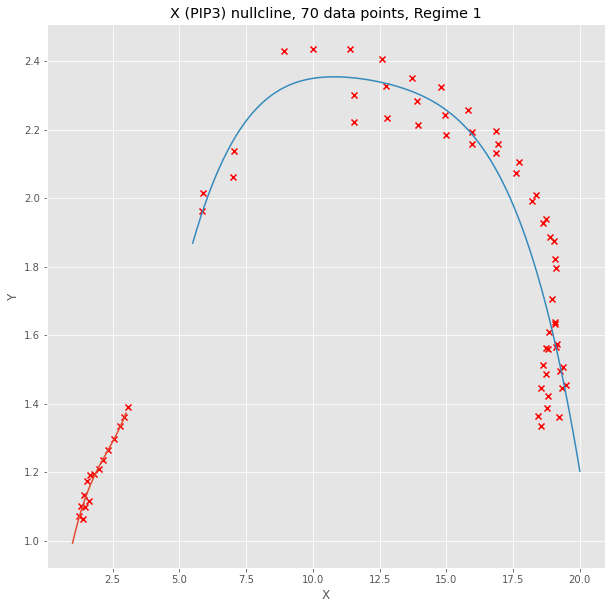

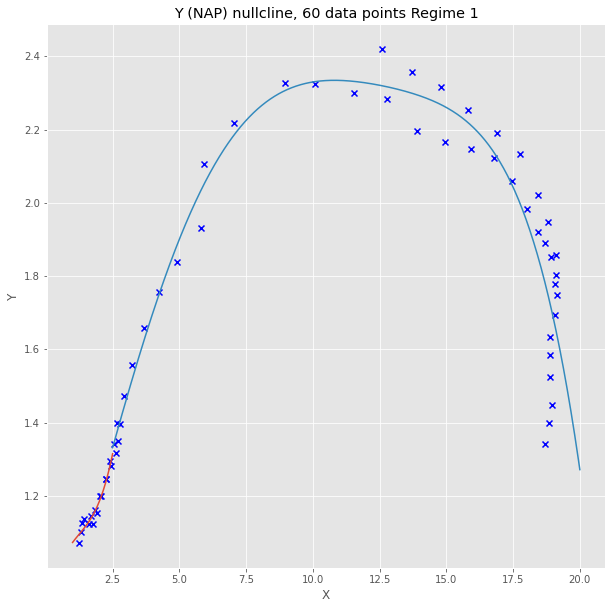

In [82]:
fig_x_null, ax_x_null = plt.subplots(figsize=(10,10))
fig_y_null, ax_y_null = plt.subplots(figsize=(10,10))

# X Nullcline
ax_x_null.scatter(x_null_arr_R1[:,1], x_null_arr_R1[:,2], marker = 'x', color='red')
ax_x_null.plot(np.linspace(1,3,1000),p1x1(np.linspace(1,3,1000)))
ax_x_null.plot(np.linspace(5.5,20,1000),p1x2(np.linspace(5.5,20,1000)))
ax_x_null.set_xlabel('X')
ax_x_null.set_ylabel('Y')
ax_x_null.set_title("X (" + X_chem + ") nullcline, " + str(len(x_null_arr_R1)) + " data points, " + "Regime 1")

# Y Nullcline
ax_y_null.scatter(y_null_arr_R1[:,1], y_null_arr_R1[:,2], marker='x', color='blue')
ax_y_null.plot(np.linspace(1,2.5,1000),p1y1(np.linspace(1,2.5,1000)))
ax_y_null.plot(np.linspace(2.5,20,1000),p1y2(np.linspace(2.5,20,1000)))
ax_y_null.set_xlabel('X')
ax_y_null.set_ylabel('Y')
ax_y_null.set_title("Y (" + Y_chem + ") nullcline, " + str(len(y_null_arr_R1)) + " data points " + "Regime 1")


### Regime 2

In [83]:
ulim = 36
llim = 27

x_null_arr_R2 = time_isolator(full_X_null, ulim, llim, 0)
y_null_arr_R2 = time_isolator(full_Y_null, ulim, llim, 0)

In [84]:
# X nullcline regime 1 sub-regimes
sub2_x_1 = x_null_arr_R2[x_null_arr_R2[:,1]<5]
p2x1 = np.poly1d(np.polyfit(sub2_x_1[:,1], sub2_x_1[:,2], 2))

sub2_x_2 = x_null_arr_R2[x_null_arr_R2[:,1]>=5]
p2x2 = np.poly1d(np.polyfit(sub2_x_2[:,1], sub2_x_2[:,2], 4))


# Y nullcline regime 1 sub-regimes
sub2_y_1 = y_null_arr_R2[y_null_arr_R2[:,1]<20]
p2y1 = np.poly1d(np.polyfit(sub2_y_1[:,1], sub2_y_1[:,2], 6))


Text(0.5, 1.0, 'Y (NAP) nullcline, 35 data points Regime 2')

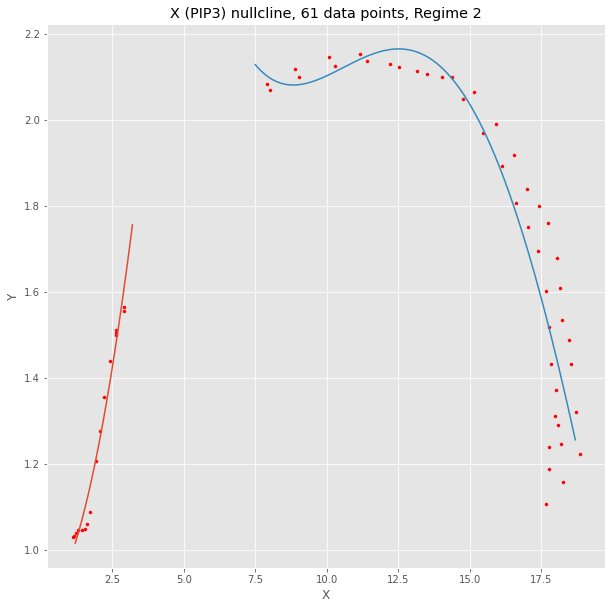

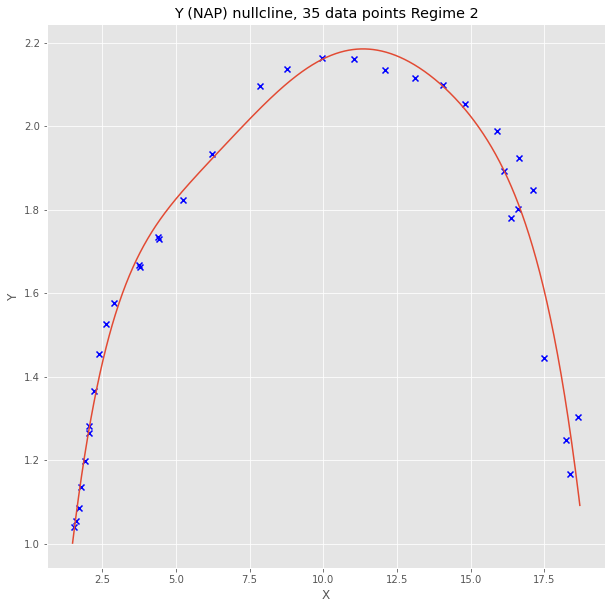

In [85]:

fig_x_null, ax_x_null = plt.subplots(figsize=(10,10))
fig_y_null, ax_y_null = plt.subplots(figsize=(10,10))

# X Nullcline
ax_x_null.scatter(x_null_arr_R2[:,1], x_null_arr_R2[:,2], marker = '.', color='red')
ax_x_null.plot(np.linspace(1.2,3.2,1000),p2x1(np.linspace(1.2,3.2,1000)))
ax_x_null.plot(np.linspace(7.5,18.7,1000),p2x2(np.linspace(7.5,18.7,1000)))
ax_x_null.set_xlabel('X')
ax_x_null.set_ylabel('Y')
ax_x_null.set_title("X (" + X_chem + ") nullcline, " + str(len(x_null_arr_R2)) + " data points, " + "Regime 2")

# Y Nullcline
ax_y_null.scatter(y_null_arr_R2[:,1], y_null_arr_R2[:,2], marker='x', color='blue')
ax_y_null.plot(np.linspace(1.5,18.7,1000),p2y1(np.linspace(1.5, 18.7,1000)))
ax_y_null.set_xlabel('X')
ax_y_null.set_ylabel('Y')
ax_y_null.set_title("Y (" + Y_chem + ") nullcline, " + str(len(y_null_arr_R2)) + " data points " + "Regime 2")


### Regime 3

In [86]:
ulim = 18
llim = 3

x_null_arr_R3 = time_isolator(full_X_null, ulim, llim, 0)
y_null_arr_R3 = time_isolator(full_Y_null, ulim, llim, 0)

In [87]:
# X nullcline regime 1 sub-regimes
sub3_x_1 = x_null_arr_R3[x_null_arr_R3[:,1]<11]
p3x1 = np.poly1d(np.polyfit(sub3_x_1[:,1], sub3_x_1[:,2], 4))

sub3_x_2 = x_null_arr_R3[x_null_arr_R3[:,1]>=11]
p3x2 = np.poly1d(np.polyfit(sub3_x_2[:,1], sub3_x_2[:,2], 3))


# Y nullcline regime 1 sub-regimes
sub3_y_1 = y_null_arr_R3[y_null_arr_R3[:,1]<20]
p3y1 = np.poly1d(np.polyfit(sub3_y_1[:,1], sub3_y_1[:,2], 4))


Text(0.5, 1.0, 'Y (NAP) nullcline, 80 data points Regime 3')

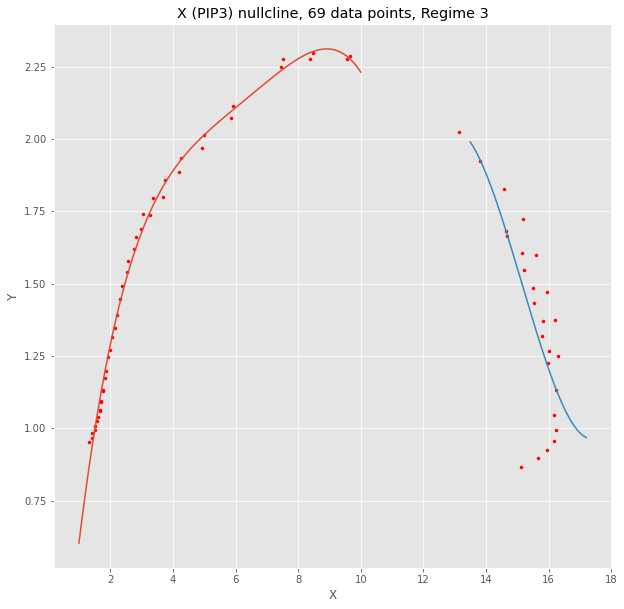

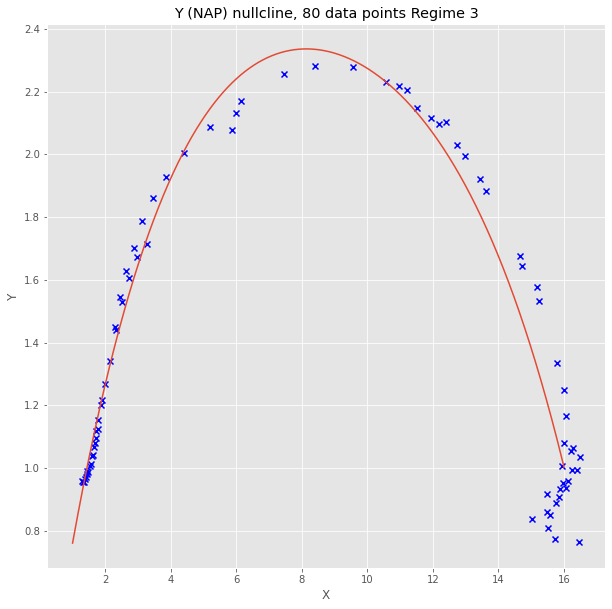

In [88]:

fig_x_null, ax_x_null = plt.subplots(figsize=(10,10))
fig_y_null, ax_y_null = plt.subplots(figsize=(10,10))

# X Nullcline
ax_x_null.scatter(x_null_arr_R3[:,1], x_null_arr_R3[:,2], marker = '.', color='red')
ax_x_null.plot(np.linspace(1,10,1000),p3x1(np.linspace(1,10,1000)))
ax_x_null.plot(np.linspace(13.5,17.2,1000),p3x2(np.linspace(13.5,17.2,1000)))
ax_x_null.set_xlabel('X')
ax_x_null.set_ylabel('Y')
ax_x_null.set_title("X (" + X_chem + ") nullcline, " + str(len(x_null_arr_R3)) + " data points, " + "Regime 3")

# Y Nullcline
ax_y_null.scatter(y_null_arr_R3[:,1], y_null_arr_R3[:,2], marker='x', color='blue')
ax_y_null.plot(np.linspace(1,16,1000),p3y1(np.linspace(1,16,1000)))
ax_y_null.set_xlabel('X')
ax_y_null.set_ylabel('Y')
ax_y_null.set_title("Y (" + Y_chem + ") nullcline, " + str(len(y_null_arr_R3)) + " data points " + "Regime 3")



### Report Diagrams

In [49]:
x,y = np.meshgrid(np.linspace(1,21,20),np.linspace(0.3,2.6,20))

u = x_p[0]*x**2+x_p[1]*x+x_p[2]-y
v = y_p[0]*x**2+y_p[1]*x+y_p[2]-y

plt.quiver(data_stack[:,0],data_stack[:,1], data_stack[:,2], data_stack[:,3], color = 'g' )
plt.plot(x_range[idx], dY_curve_y[idx], 'ro')
plt.quiver(x,y,u,v)
plt.show()

NameError: name 'x_p' is not defined